In [1]:
from DarkMatter import *

dwarf = "bootes"
events= Likelihood.eventdisplay.readData(dwarf, rawdata=True)
sig = events[events[:,2] == 1.0]
bkg = events[events[:,2] == 0.0]
binEdges = const.energyEdges

Welcome to JupyROOT 6.23/01


## Purpose: The current method for calculating the likelihood of background for on-region high-energy events has two problems. 

- First of all, we use histogram with equal-spaced bins to build a probability density function. If we have enough data, this does not a problem. However, if not, the probability density function depends on the selection of bin edges.

- Secondly, we don't have enough high-energy background events to build a continuous probabilty density function.


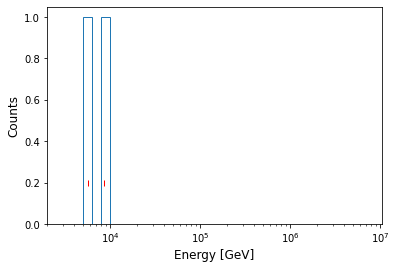

In [2]:
plt.hist(events[:,0][events[:,0]>5000], bins=binEdges, histtype="step")
plt.plot(events[:,0][events[:,0]>5000][:,None], np.full_like(events[:,0][events[:,0]>5000][:,None], 0.2), '|k', markeredgewidth=1, color="r")
plt.xlim(2000, )
plt.xlabel("Energy [GeV]", fontsize=12)
plt.ylabel("Counts", fontsize=12)
plt.xscale("log")

### Raw Data (Null model)

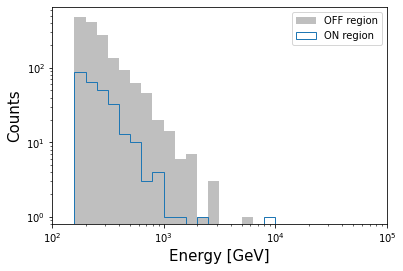

In [3]:
def cstat(x, m, s=True):
    if s:
        return 2*sum(m- x+x*(np.nan_to_num(np.log(x))-np.nan_to_num(np.log(m))))
    else:
        return 2*(m- x+x*(np.nan_to_num(np.log(x))-np.nan_to_num(np.log(m))))
    
def get_center(x):
    return (x[1:]+x[:-1])/2.

def rawdata_plot(events, binEdges, ylim=[0.1, None], ax=None, label="Raw data"):
    if ax == None:
        ax = plt.gca()
    y, x, etc = ax.hist(events, bins=binEdges,  histtype="stepfilled", label=label, color="gray", alpha=0.5)
#    ax.plot(events[:,None], np.full_like(events[:,None], ylim[0]*1.2), '|k', markeredgewidth=1)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_ylim(ylim[0], ylim[1])
    ax.set_xlabel("Energy [GeV]", fontsize=15)
    ax.set_ylabel("Counts", fontsize=15)
    ax.legend(frameon=False, fontsize=15)
    return x, y

x, y = rawdata_plot(bkg[:,0], binEdges, label="OFF region")
plt.hist(sig[:,0], binEdges, histtype="step", label="ON region")
x_ctr = get_center(x)
plt.ylim(0.8,)
plt.xlim(100, 100000)
plt.legend()

### Method 1. Smoothing

<ipython-input-3-cc0b194fde1a>:3: RuntimeWarning: divide by zero encountered in log
  return 2*sum(m- x+x*(np.nan_to_num(np.log(x))-np.nan_to_num(np.log(m))))


Model counts: 1564
Raw counts: 1564
Cash stat: 4.39


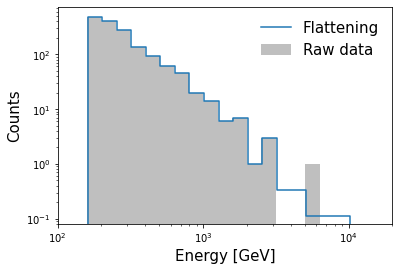

In [36]:
y_sm = Likelihood.EventDisplay.bkg_sm_1D(events, binEdges)
plt.step(x_ctr, y_sm, where="mid", label="Flattening")
x, y = rawdata_plot(bkg[:,0], binEdges, ylim=[0.03, None])
#plt.axvline(max(events[:,0]), color="r", ls=":")
plt.ylim(0.08,)
plt.xlim(100, 20000)
cstat_sm = cstat(y, y_sm)

print("Model counts: {:.0f}".format(sum(y_sm)))
print("Raw counts: {:.0f}".format(sum(y)))
print("Cash stat: {:.2f}".format(cstat_sm))

### Method 2. Extrapolation

Model counts: 1564
Raw counts: 1564
Cash stat: 8.60 (dof = 59)


<ipython-input-3-cc0b194fde1a>:3: RuntimeWarning: divide by zero encountered in log
  return 2*sum(m- x+x*(np.nan_to_num(np.log(x))-np.nan_to_num(np.log(m))))


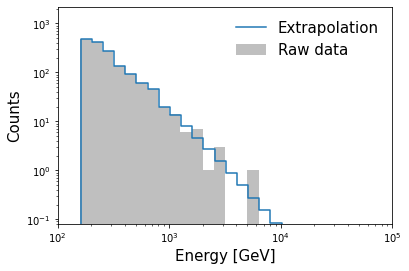

In [5]:
y_ex =  Likelihood.EventDisplay.bkg_ex_1D(events, binEdges, eMin=600, eMax=10000, order=2)
plt.step(center_pt(binEdges), y_ex, where="mid", label="Extrapolation")
x, y = rawdata_plot(bkg[:,0], binEdges, ylim = [1e-2, None])
#plt.axvline(max(events[:,0]), color="r", ls=":")

cstat_ex = cstat(y, y_ex)
plt.ylim(0.08,)
plt.xlim(100, 100000)

print("Model counts: {:.0f}".format(sum(y_ex)))
print("Raw counts: {:.0f}".format(sum(y)))
print("Cash stat: {:.2f} (dof = {})".format(cstat_ex, len(y)-1))

### Compare the methods

<ipython-input-9-8496979cb482>:9: RuntimeWarning: invalid value encountered in true_divide
  ax[1].step(x_ctr, (y-y_sm)/np.sqrt(y_sm), where="mid", label="Smoothing")
<ipython-input-9-8496979cb482>:10: RuntimeWarning: invalid value encountered in true_divide
  ax[1].step(x_ctr, (y-y_ex)/np.sqrt(y_ex), where="mid", label="Extrapolation")


(50, 700000.0)

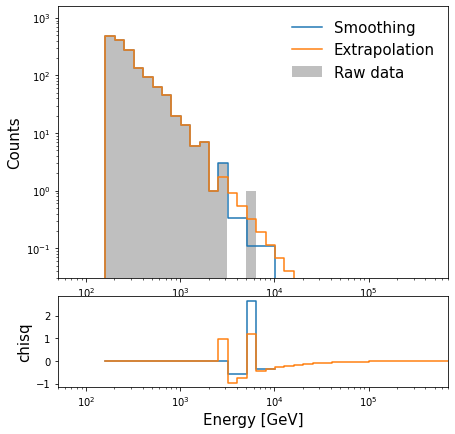

In [9]:
f, ax = plt.subplots(2,1, figsize=(7, 7), gridspec_kw={'height_ratios': [3, 1]})
plt.subplots_adjust(hspace=0.1)
ax[0].step(x_ctr, y_sm, where="mid", label="Smoothing")
ax[0].step(x_ctr, y_ex, where="mid", label="Extrapolation")

x, y = rawdata_plot(bkg[:,0], binEdges, ylim=[0.03, None], ax=ax[0])
ax[0].set_xlim(50, 7e5)

ax[1].step(x_ctr, (y-y_sm)/np.sqrt(y_sm), where="mid", label="Smoothing")
ax[1].step(x_ctr, (y-y_ex)/np.sqrt(y_ex), where="mid", label="Extrapolation")
ax[1].set_xscale("log")

ax[1].set_xlabel("Energy [GeV]", fontsize=15)
ax[1].set_ylabel("chisq", fontsize=15)
ax[1].set_xlim(50, 7e5)

### Convert to the probability density function (PDF)

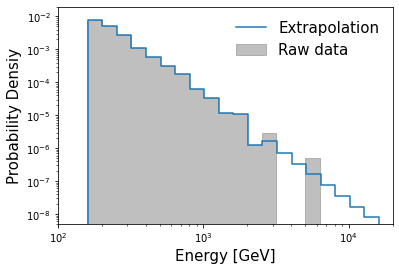

Warning in <TROOT::Append>: Replacing existing TH1: Null (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Smoothing (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Extrapolation (Potential memory leak).


In [34]:
y_raw_pdf = y/np.diff(x)
y_raw_pdf = y_raw_pdf/sum(y_raw_pdf*np.diff(x))
y_sm_pdf = y_sm/np.diff(x)
y_sm_pdf = y_sm_pdf/sum(y_sm_pdf*np.diff(x))
y_ex_pdf = y_ex/np.diff(x)
y_ex_pdf = y_ex_pdf/sum(y_ex_pdf*np.diff(x))

hBkg = TH1D("Null", "Probability Density Function", len(x)-2, x)
hBkg_sm = TH1D("Smoothing", "Probability Density Function", len(x)-2, x)
hBkg_ex = TH1D("Extrapolation", "Probability Density Function", len(x)-2, x)

for i in range(1, len(x)):
    hBkg.SetBinContent(i, y_raw_pdf[i-1])
    hBkg_sm.SetBinContent(i, y_sm_pdf[i-1])
    hBkg_ex.SetBinContent(i, y_ex_pdf[i-1])

#plt.step(x_ctr, y_raw_pdf, where="mid", label="Flattening", )
#plt.step(x_ctr, y_sm_pdf, where="mid", label="Flattening")
plt.step(x_ctr, y_ex_pdf, where="mid", label="Extrapolation")
plt.fill_between(x[1:],y_raw_pdf, step="pre", alpha=0.5, color="gray", label="Raw data") 
plt.xlabel("Energy [GeV]", fontsize=15)
plt.ylabel("Probability Densiy", fontsize=15)
plt.xlim(100, 20000)
plt.ylim(5e-9,2e-2)
plt.xscale("log")
plt.yscale("log")
plt.legend(frameon=False, fontsize=15)

### Assign likelihood for on-region events

In [11]:

events= Likelihood.eventdisplay.readData(dwarf, rawdata=True)

signal = events[events[:,2] == 1.0][:,0]

print("e.g.,   Energy         Null         SM                EX        ")
print("-"*85)
for j, evt in enumerate(signal):
    if evt < 500 and j<=5:
        print("{:10.0f} [GeV] {:10.2f} {:10.2f}({:5.2f}) {:10.2f}({:5.2f}))"
            .format(evt, np.log(hBkg.Interpolate(evt)), \
                     np.log(hBkg_sm.Interpolate(evt)), -np.log(hBkg.Interpolate(evt))+np.log(hBkg_sm.Interpolate(evt)), \
                     np.log(hBkg_ex.Interpolate(evt)), -np.log(hBkg.Interpolate(evt))+np.log(hBkg_ex.Interpolate(evt))))
        
signal.sort()
print("-"*85)
for k, evt in enumerate(signal[::-1]):
    if k <=7:    
        print("{:10.0f} [GeV] {:10.2f} {:10.2f}({:5.2f}) {:10.2f}({:5.2f})"
            .format(evt, np.log(hBkg.Interpolate(evt)), \
                     np.log(hBkg_sm.Interpolate(evt)), -np.log(hBkg.Interpolate(evt))+np.log(hBkg_sm.Interpolate(evt)), \
                     np.log(hBkg_ex.Interpolate(evt)), -np.log(hBkg.Interpolate(evt))+np.log(hBkg_ex.Interpolate(evt))))

e.g.,   Energy         Null         SM                EX        
-------------------------------------------------------------------------------------
       161 [GeV]      -5.54      -5.54( 0.00)      -5.54( 0.00))
       217 [GeV]      -5.20      -5.20( 0.00)      -5.20( 0.00))
       283 [GeV]      -5.91      -5.91( 0.00)      -5.91( 0.00))
       186 [GeV]      -4.93      -4.93( 0.00)      -4.93( 0.00))
       252 [GeV]      -5.53      -5.53( 0.00)      -5.53( 0.00))
       160 [GeV]      -5.63      -5.63( 0.00)      -5.63( 0.00))
-------------------------------------------------------------------------------------
      8627 [GeV]       -inf     -17.13(  inf)     -16.95(  inf)
      2036 [GeV]     -12.06     -12.06( 0.00)     -12.06( 0.00)
      1479 [GeV]     -11.36     -11.36( 0.00)     -11.36( 0.00)
      1218 [GeV]     -10.50     -10.50( 0.00)     -10.50( 0.00)
       949 [GeV]      -9.79      -9.79( 0.00)      -9.79( 0.00)
       929 [GeV]      -9.75      -9.75( 0.00)      -9

<ipython-input-11-cc68dd90c0ed>:19: RuntimeWarning: divide by zero encountered in log
  .format(evt, np.log(hBkg.Interpolate(evt)), \
<ipython-input-11-cc68dd90c0ed>:20: RuntimeWarning: divide by zero encountered in log
  np.log(hBkg_sm.Interpolate(evt)), -np.log(hBkg.Interpolate(evt))+np.log(hBkg_sm.Interpolate(evt)), \
<ipython-input-11-cc68dd90c0ed>:21: RuntimeWarning: divide by zero encountered in log
  np.log(hBkg_ex.Interpolate(evt)), -np.log(hBkg.Interpolate(evt))+np.log(hBkg_ex.Interpolate(evt))))


In [12]:
events= Likelihood.eventdisplay.readData(dwarf, rawdata=True)

signal = events[events[:,2] == 1.0][:,0]
likelihoodSet = []
for j, evt in enumerate(signal):
    likelihoodSet.append([hBkg.Interpolate(evt), hBkg_sm.Interpolate(evt), hBkg_ex.Interpolate(evt)])

likelihoodSet = np.asarray(likelihoodSet)
num_poff_zero = [sum(likelihoodSet[:,0]==0), sum(likelihoodSet[:,1]==0), sum(likelihoodSet[:,2]==0)]

print("The number of events which has p_off of 0:")
print("Null model: \t", num_poff_zero[0])
print("SM model: \t", num_poff_zero[1])
print("Ex model: \t", num_poff_zero[2])

The number of events which has p_off of 0:
Null model: 	 1
SM model: 	 0
Ex model: 	 0


where Raw: no background model | 
SM: Smoothing | 
EX: Extrapolation | 
KDE: Kernel density estimation.

Note that

- For low energies, four models assign similar likelihood.
- For high energies, the EX and KDE models provide similar likelihood.
- For high energies, sometimes, the Raw model does not assign likelihood (-inf) for on-region events (e.g., 9712 GeV).
- The KDE model tends to provide the lowest likelihood between three models.
- As the energy decreases, the Raw and SM models provide similar likelihood.

### Likelihood analysis and upper limits

In [15]:
dwarf = "bootes"
decay = "tt"
package="EventDisplay"
jProfile=None
irf=None
mass = np.logspace(2, 4.5, 15)
jSeed=defaultNum[dwarf]

output="no"
Likelihood.calcUpperLimits(dwarf, decay, package=package, irf=irf, ext=False,
                           mass=mass, method=2, addTheta=False, useBias=True, jArray=True, jSeed=jSeed,
                           filename=output, averagedIRF=True)

output="sm"
Likelihood.calcUpperLimits(dwarf, decay, package=package, irf=irf, ext=False,
                           mass=mass, method=2, addTheta=False, useBias=True,  jArray=True, jSeed=jSeed,
                           filename=output, bkgModel="sm", averagedIRF=True)

output="ex"
Likelihood.calcUpperLimits(dwarf, decay, package=package, irf=irf, ext=False,
                           mass=mass, method=2, addTheta=False, useBias=True,  jArray=True, jSeed=jSeed, 
                           filename=output, bkgModel="ex", averagedIRF=True)



[Log] Package      : EventDisplay
[Log] Dwarf        : bootes
[Log] Channel      : tt
[Log] Dataset      : Point-like
[Log] Dimention    : 1
[Log] Background   : None
[Log] Dispersion   : Etr vs ratio
[Log] Minimum mass : 100 GeV
[Log] Maximum mass : 32 TeV


  0%|          | 0/15 [00:00<?, ?it/s]

[Warning] 1 events have p_bkg of 0. They are ignored when calculating the likelihood.
[Warning] 1 events have p_bkg of 0. They are ignored when calculating the likelihood.
[Warning] 1 events have p_bkg of 0. They are ignored when calculating the likelihood.
[Warning] 1 events have p_bkg of 0. They are ignored when calculating the likelihood.
[Warning] 1 events have p_bkg of 0. They are ignored when calculating the likelihood.
[Warning] 1 events have p_bkg of 0. They are ignored when calculating the likelihood.
[Warning] 1 events have p_bkg of 0. They are ignored when calculating the likelihood.
[Warning] 1 events have p_bkg of 0. They are ignored when calculating the likelihood.
[Warning] 1 events have p_bkg of 0. They are ignored when calculating the likelihood.
[Warning] 1 events have p_bkg of 0. They are ignored when calculating the likelihood.
[Warning] 1 events have p_bkg of 0. They are ignored when calculating the likelihood.
[Warning] 1 events have p_bkg of 0. They are ignored w

  0%|          | 0/15 [00:00<?, ?it/s]

[Log] Upper limits are saved in '/Users/dtak/Research/DarkMatter/Output/sm.npy'
[Log] Package      : EventDisplay
[Log] Dwarf        : bootes
[Log] Channel      : tt
[Log] Dataset      : Point-like
[Log] Dimention    : 1
[Log] Background   : Extrapolation (ex)
[Log] Dispersion   : Etr vs ratio
[Log] Minimum mass : 100 GeV
[Log] Maximum mass : 32 TeV


  0%|          | 0/15 [00:00<?, ?it/s]

[Log] Upper limits are saved in '/Users/dtak/Research/DarkMatter/Output/ex.npy'


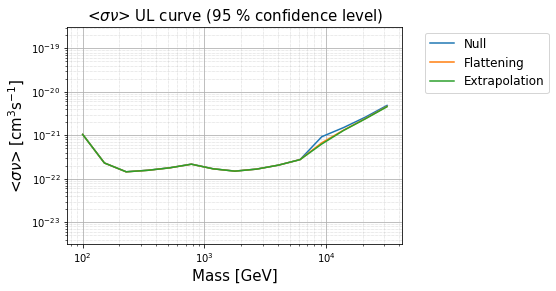

In [16]:
Likelihood.plotULcurve("no.npy", label="Null")
Likelihood.plotULcurve("sm.npy", label="Flattening")
Likelihood.plotULcurve("ex.npy", label="Extrapolation")